Usando o exemplo 499

In [44]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install lime

%pip install imbalanced-learn

%pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
#importando pacotes e bibliotecas para um SVM

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
#from sklearn.feature_extraction.text import CountVectorizer #converter os textos em uma matriz
from sklearn.feature_extraction.text import TfidfTransformer #frequencia que o termo aparece
from lime.lime_text import LimeTextExplainer

#from sklearn.svm import LinearSVC, SVC # dados lineares / não lineares
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [46]:
#importando dataset

df = pd.read_csv("../all-data.csv")

In [47]:
df.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [48]:
df.shape

(4846, 2)

<Axes: xlabel='sentiment', ylabel='count'>

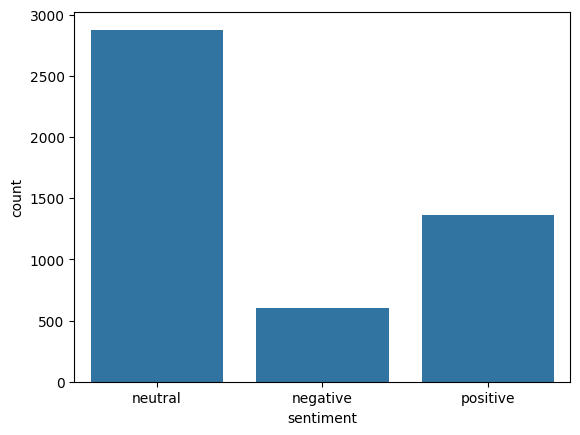

In [49]:
#exibindo os dados em um gráfico de barras
sns.countplot(x='sentiment', data=df)

**Pré-processamento**

In [50]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [51]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [52]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [53]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

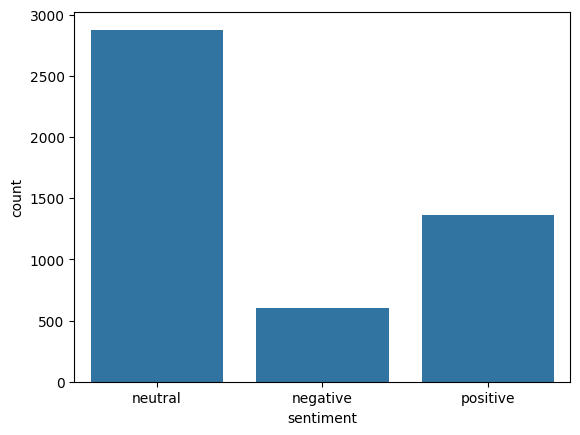

In [54]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

**UNDERSAMPLING**

In [55]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Separar features e rótulos
X = df["clean_text"]
y = df["sentiment"]

# Dividir em treino e teste antes do balanceamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vetorização dos textos (CountVectorizer)
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)  # Apenas transform, sem fit

# Aplicar undersampling APENAS no conjunto de treino
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vect, y_train)

<Axes: xlabel='sentiment', ylabel='count'>

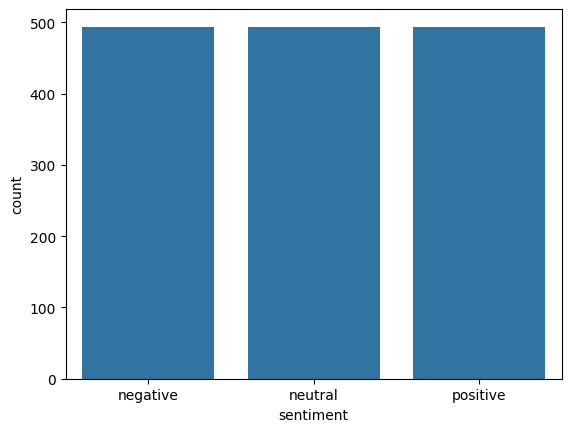

In [56]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

TREINAMENTO

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from imblearn.under_sampling import RandomUnderSampler

# Pipeline completo (inclui vetorização)
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

# Balanceamento APENAS no treino
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train.to_frame(), y_train)
X_train_resampled = X_train_resampled.squeeze()  # volta para Series

# Treinamento do pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

,steps,"[('vect', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [58]:
# Realiza a predição no conjunto de teste
y_pred = pipeline.predict(X_test)

**LIME**

In [59]:
# Assuming 'text' is the column name containing the text data and 'sentiment' is the target column
X = df['text']
y = df['sentiment']

In [60]:
#X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["sentiment"], test_size=0.2, random_state=42)

In [61]:
from IPython.display import display
from lime.lime_text import LimeTextExplainer

# Criando o explainer
explainer = LimeTextExplainer(class_names=list(pipeline.classes_))

def predict_proba(texts):
    # LIME espera probabilidades, mas LinearSVC não tem predict_proba.
    # Usamos decision_function e normalizamos para somar 1 (softmax-like).
    scores = pipeline.decision_function(texts)
    import numpy as np
    # Se for 1D (binary), transforma em 2D
    if len(scores.shape) == 1:
        scores = np.vstack([-scores, scores]).T
    # Softmax para converter scores em "probabilidades"
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
    return probs

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
pred_class_name = pipeline.predict([sample_text])[0]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Real class: {sample_label}")
print(f"Classe predita: {pred_class_name}")


explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

Número da linha no X_test: 499
Original text:
preliminary estimation technology park measure square meter
Real class: neutral
Classe predita: neutral


In [62]:
import matplotlib.pyplot as plt

# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")


Palavras mais importantes e seus pesos:
square: 0.0996
park: -0.0548
technology: -0.0524
estimation: 0.0404
preliminary: 0.0371
meter: 0.0315
measure: 0.0090


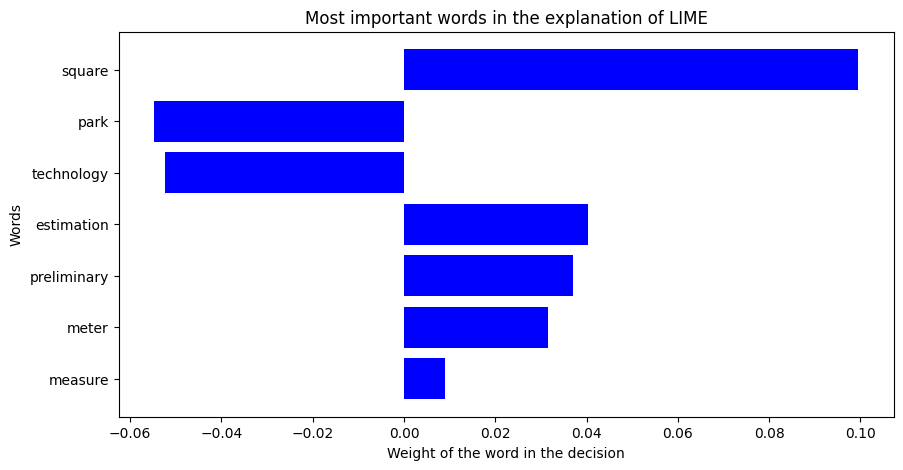

In [63]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [64]:
explanation_list = explanation.as_list()
lime_df = pd.DataFrame(explanation_list, columns=["Word", "Impact"])

# Ordenar por impacto
lime_df = lime_df.sort_values(by="Impact", ascending=False)

display(lime_df.head(20))  # Exibir as 20 palavras mais impactantes

,Word,Impact
0,square,0.099569
3,estimation,0.040397
4,preliminary,0.037060
5,meter,0.031547
6,measure,0.008974
2,technology,-0.052372
1,park,-0.054785


<Figure size 1000x600 with 0 Axes>

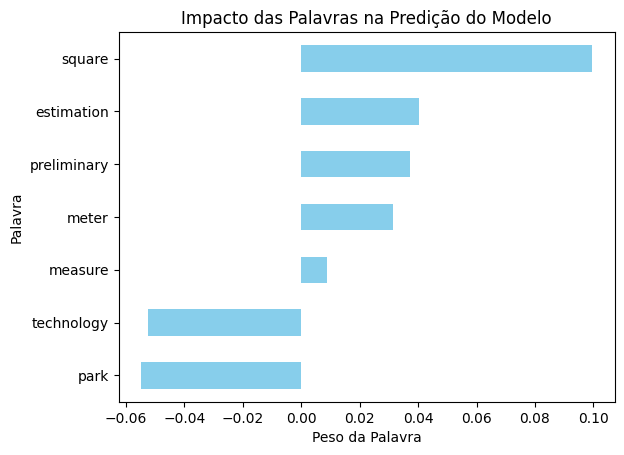

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lime_df.plot(kind="barh", x="Word", y="Impact", color="skyblue", legend=False)
plt.xlabel("Peso da Palavra")
plt.ylabel("Palavra")
plt.title("Impacto das Palavras na Predição do Modelo")
plt.gca().invert_yaxis()  # Inverte o eixo para as palavras mais importantes ficarem no topo
plt.show()

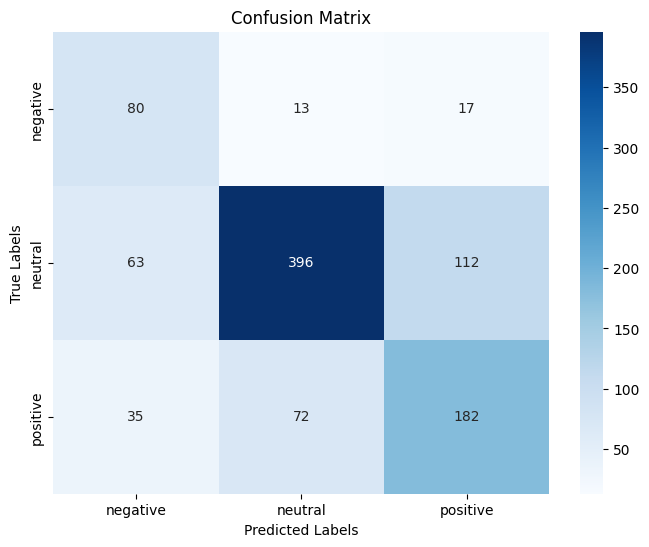

In [66]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


**Métricas**

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Usando 'weighted' para classes múltiplas
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Acuraccy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acuraccy: 0.6784
Precision: 0.7100
Recall: 0.6784
F1-Score: 0.6869


**Attention Vizualization**

In [68]:
print(pipeline.classes_)

['negative' 'neutral' 'positive']


Palavras do exemplo e seus pesos na decisão da classe prevista:
          Feature    Weight
3512       square  0.587181
1188   estimation  0.254300
2865  preliminary  0.251251
2296        meter  0.217478
2259      measure  0.199806
2685         park -0.172923
3740   technology -0.275615


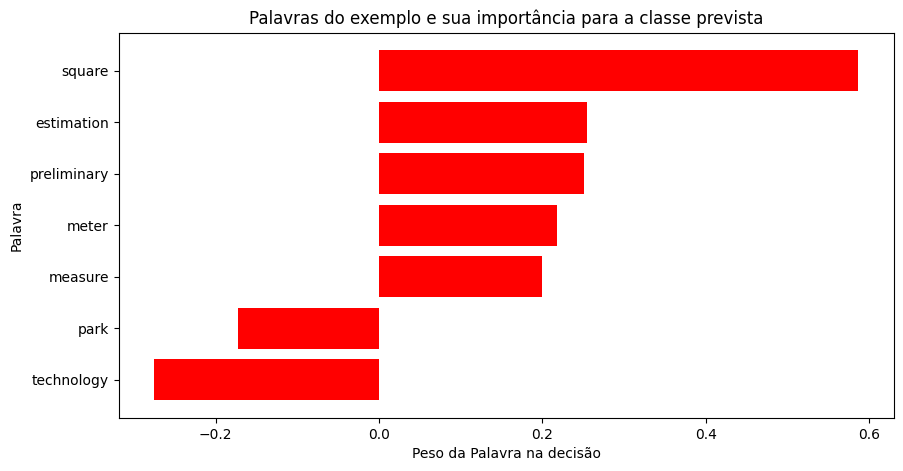

In [69]:
# Obter os nomes das features do CountVectorizer
feature_names = pipeline.named_steps['vect'].get_feature_names_out()

# Obter os coeficientes do SVM para a classe prevista
classe_prevista = pipeline.predict([sample_text])[0]
classe_idx = list(pipeline.classes_).index(classe_prevista)
pesos = pipeline.named_steps['clf'].coef_[classe_idx]

# Criar DataFrame com as features e pesos
importancias = pd.DataFrame({'Feature': feature_names, 'Weight': pesos})

# Marcar as palavras do exemplo
palavras_exemplo = set(sample_text.split())
importancias['No_Exemplo'] = importancias['Feature'].apply(lambda x: x in palavras_exemplo)

# Visualizar as palavras do exemplo e seus pesos
importancias_exemplo = importancias[importancias['No_Exemplo']].sort_values(by='Weight', ascending=False)

print("Palavras do exemplo e seus pesos na decisão da classe prevista:")
print(importancias_exemplo[['Feature', 'Weight']])

# Plotar as palavras do exemplo
plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo['Feature'], importancias_exemplo['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title("Palavras do exemplo e sua importância para a classe prevista")
plt.gca().invert_yaxis()
plt.show()

Shapley

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


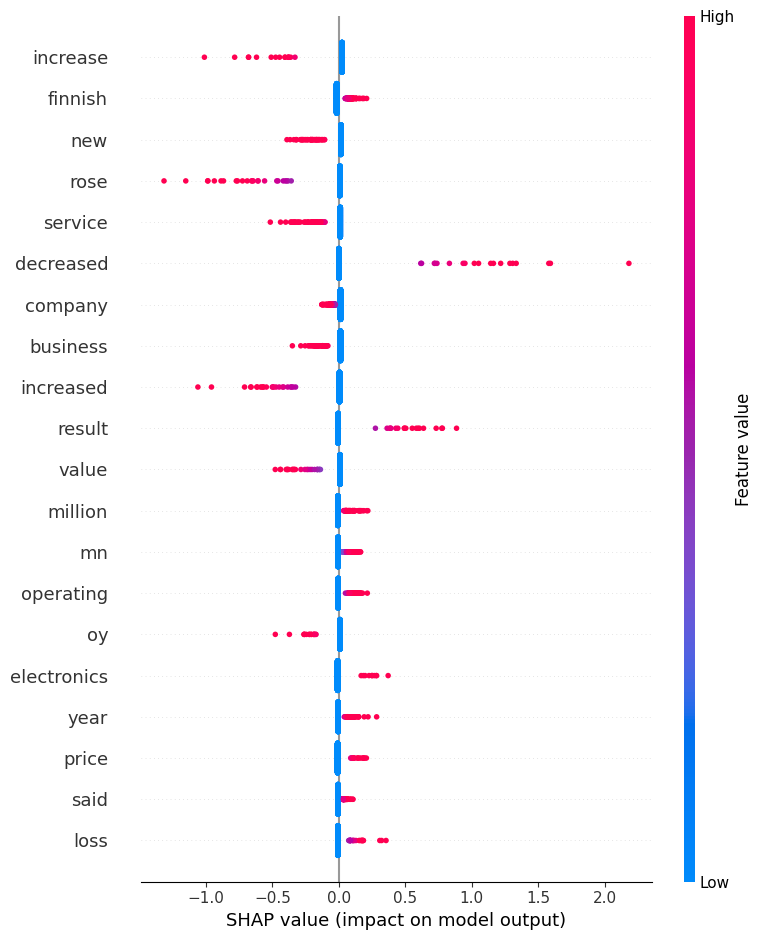

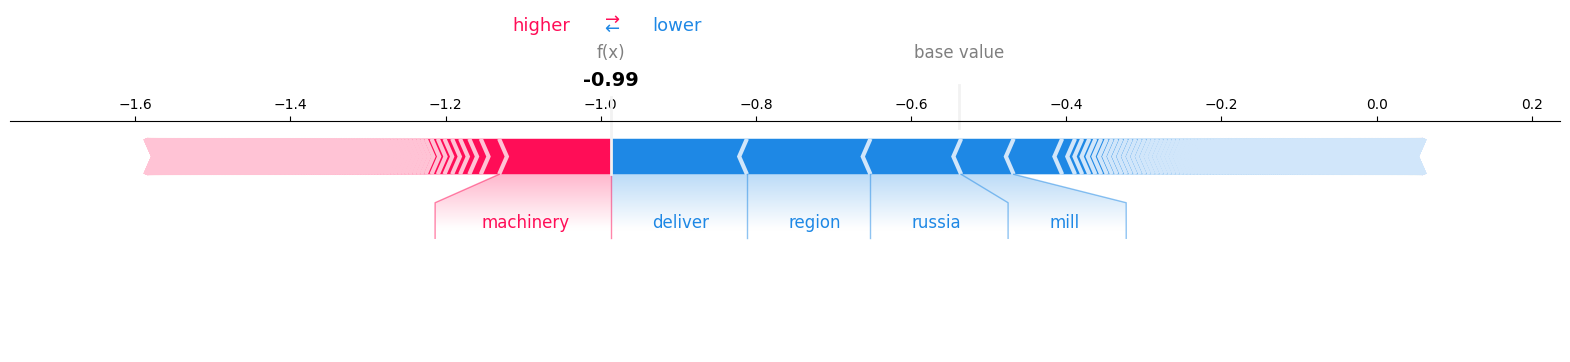

In [70]:
# Transformar os dados usando o pipeline (sem o classificador)
X_train_transformed = pipeline.named_steps['tfidf'].transform(
    pipeline.named_steps['vect'].transform(X_train)
)

X_test_transformed = pipeline.named_steps['tfidf'].transform(
    pipeline.named_steps['vect'].transform(X_test)
)

# Selecionar um subconjunto do treino como background (melhora performance e evita estouro de memória)
background_size = 100
background = X_train_transformed[np.random.choice(X_train_transformed.shape[0], 
                                                  min(background_size, X_train_transformed.shape[0]), 
                                                  replace=False)]

# Criar o explainer para modelo linear
explainer = shap.LinearExplainer(
    pipeline.named_steps['clf'],
    background,
    feature_perturbation="interventional"
)

# Calcular valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test_transformed)

# Obter nomes das features
feature_names = pipeline.named_steps['vect'].get_feature_names_out()

X_test_dense = X_test_transformed.toarray()
feature_names = pipeline.named_steps['vect'].get_feature_names_out()

class_idx = 0  # escolha a classe (0=neg, 1=neu, 2=pos)

# Seleciona a classe no ÚLTIMO eixo
shap_class = shap_values[:, :, class_idx]

# Summary plot
shap.summary_plot(
    shap_class,
    X_test_dense,
    feature_names=feature_names
)

# Force plot de uma instância
idx = 0
shap.force_plot(
    explainer.expected_value[class_idx],
    shap_class[idx],
    feature_names=feature_names,
    matplotlib=True
)


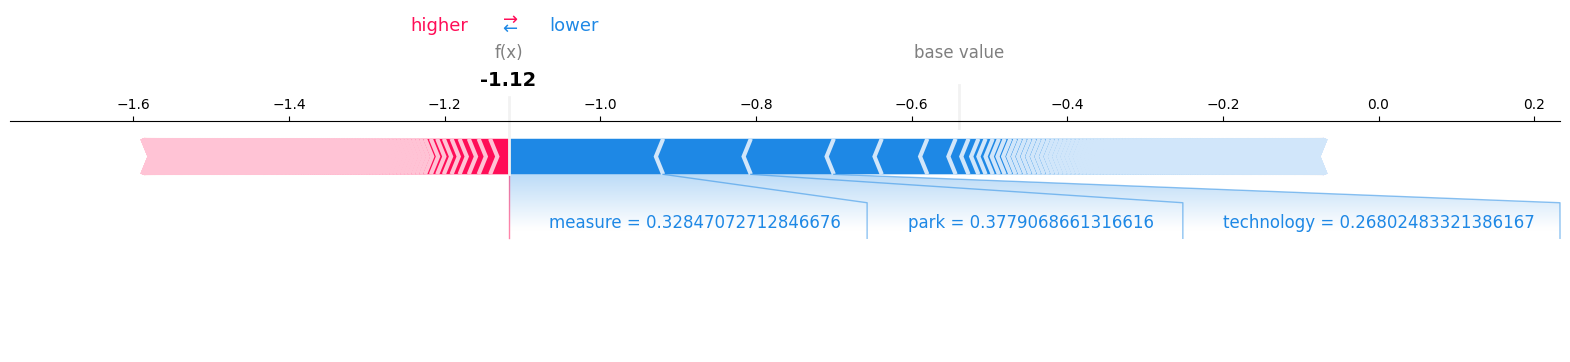

In [71]:
# =========================
# SHAP para mesma instância usada no LIME
# =========================

lime_idx = 499  # <<< coloque aqui o mesmo índice usado no LIME
class_idx = 0  # mesma classe analisada no LIME

X_test_dense = X_test_transformed.toarray()

# Seleciona a classe correta
shap_class = shap_values[:, :, class_idx]

# Force plot da mesma instância
shap.force_plot(
    explainer.expected_value[class_idx],
    shap_class[lime_idx],
    X_test_dense[lime_idx],
    feature_names=feature_names,
    matplotlib=True
)
